# First attempt to predict uplift with a neural network
The model will have two inputs: one for time-dependent data (client purchases) and one for time-independent data (client data).

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
clients_train = np.load('/content/gdrive/MyDrive/datasets/CFT/clients_train.npy')
clients_train.shape

(140027, 6)

In [5]:
train = pd.read_csv('/content/gdrive/MyDrive/datasets/CFT/train_modified.csv')\
    .drop(columns='client_id')
train

,Z
0,0
1,1
2,1
3,1
4,0
...,...
140022,1
140023,1
140024,0
140025,1


In [6]:
train_purch = np.load('/content/gdrive/MyDrive/datasets/CFT/train_purch_np.npy')
train_purch.shape

(140027, 118, 9)

# Train-validation split

In [7]:
train_indices, val_indices = train_test_split(train.index.to_list(),
                                              test_size=0.2,
                                              random_state=8,
                                              shuffle=True,
                                              stratify=train.Z)

In [8]:
X_indep_train = clients_train[train_indices, :]
X_indep_train.shape

(112021, 6)

In [9]:
X_indep_val = clients_train[val_indices, :]
X_indep_val.shape

(28006, 6)

In [10]:
X_dep_train = train_purch[train_indices, :, :]
X_dep_train.shape

(112021, 118, 9)

In [11]:
X_dep_val = train_purch[val_indices, :, :]
X_dep_val.shape

(28006, 118, 9)

In [12]:
y_train = train.values[train_indices]
y_train.shape

(112021, 1)

In [13]:
y_val = train.values[val_indices]
y_val.shape

(28006, 1)

# Basic model

In [19]:
time_dependent_input = keras.Input(
    shape=(118, 9),
    name='time_dependent'
)
time_independent_input = keras.Input(
    shape=(6),
    name='time_independent'
)
dep = layers.Dense(128, activation='relu')(time_dependent_input)
dep = layers.LSTM(16)(dep)

indep = layers.Dense(6, activation='relu')(time_independent_input)

x = layers.concatenate([dep, indep])

x = layers.Dense(8,  activation='relu')(x)
pred = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(
    inputs = [time_dependent_input, time_independent_input],
    outputs = [pred]
)

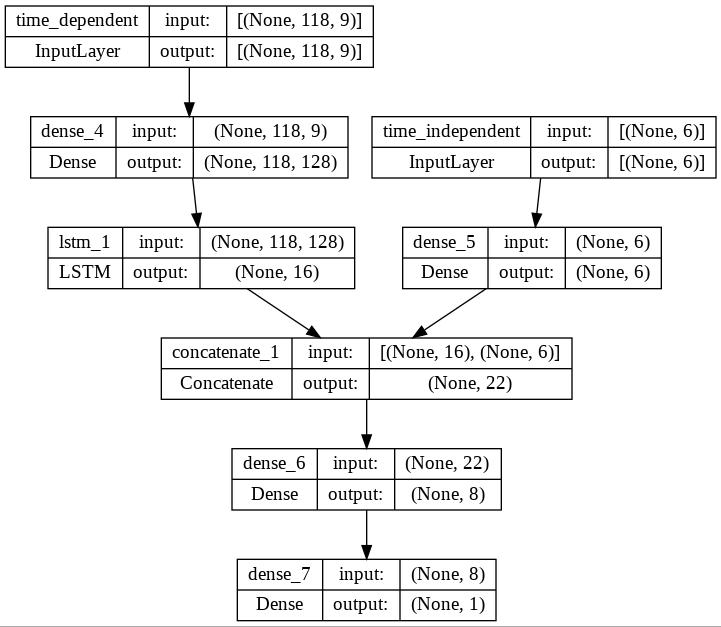

In [20]:
keras.utils.plot_model(model, 'model_1.jpg', show_shapes=True)

In [21]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=[tf.keras.metrics.AUC()]
)

In [22]:
history=model.fit(
    {'time_dependent': X_dep_train,
    'time_independent': X_indep_train},
    y_train,
    epochs=30,
    verbose=1,
    validation_split=0.1
)

Epoch 1/30
3151/3151 [==============================] - 30s 9ms/step - loss: 0.6930 - auc_1: 0.5054 - val_loss: 0.6930 - val_auc_1: 0.5092
Epoch 2/30
3151/3151 [==============================] - 29s 9ms/step - loss: 0.6926 - auc_1: 0.5094 - val_loss: 0.6933 - val_auc_1: 0.5120
Epoch 3/30
3151/3151 [==============================] - 27s 9ms/step - loss: 0.6924 - auc_1: 0.5106 - val_loss: 0.6939 - val_auc_1: 0.5041
Epoch 4/30
3151/3151 [==============================] - 27s 9ms/step - loss: 0.6923 - auc_1: 0.5123 - val_loss: 0.6930 - val_auc_1: 0.5091
Epoch 5/30
3151/3151 [==============================] - 28s 9ms/step - loss: 0.6922 - auc_1: 0.5144 - val_loss: 0.6929 - val_auc_1: 0.5071
Epoch 6/30
3151/3151 [==============================] - 28s 9ms/step - loss: 0.6921 - auc_1: 0.5147 - val_loss: 0.6933 - val_auc_1: 0.5114
Epoch 7/30
3151/3151 [==============================] - 28s 9ms/step - loss: 0.6920 - auc_1: 0.5159 - val_loss: 0.6934 - val_auc_1: 0.5107
Epoch 8/30
3151/3151 [=====

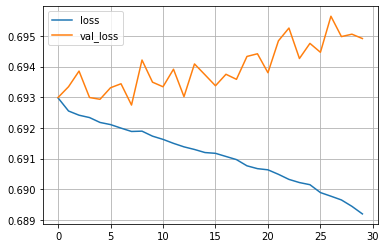

In [23]:
pd.DataFrame({'loss': history.history['loss'], 'val_loss': history.history['val_loss']})\
    .plot.line(grid=True)

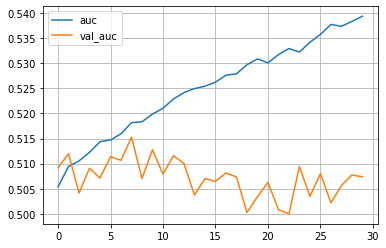

In [24]:
pd.DataFrame({'auc': history.history['auc_1'], 'val_auc': history.history['val_auc_1']})\
    .plot.line(grid=True)